In [33]:
#open pickle file to dataframe
import pandas as pd
from datetime import datetime
import pickle
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [77]:
#Load and Clean Carcass Data
carcassDf = pd.read_excel("../datafiles/GRADE Form 11-8-21 HEARTBRAND-.xlsx", sheet_name="Individual Grades ", engine='openpyxl')
carcassDf = carcassDf.iloc[5:].reset_index(drop=True)
carcassDf = carcassDf.dropna(axis=1, how='all')
carcassDf.columns = carcassDf.iloc[0]
carcassDf = carcassDf[1:].reset_index(drop=True) 
carcassDf.columns.values[4] = "Tattoo"
carcassDf['Tattoo'] = carcassDf['Tattoo'].astype(str)
carcassDf = carcassDf.rename(columns={'Weight': 'Carcass_Weight'})
carcassDf = carcassDf.dropna(how='all')
carcassDf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nan             289 non-null    float64
 1   Carcass #       285 non-null    object 
 2   TAGS            201 non-null    object 
 3   nan             285 non-null    object 
 4   Tattoo          379 non-null    object 
 5   Sex             285 non-null    object 
 6   Color           285 non-null    object 
 7   Carcass_Weight  285 non-null    object 
 8   Quality         285 non-null    object 
 9   Yield           286 non-null    object 
 10  nan             285 non-null    object 
 11  Member ID       277 non-null    object 
 12  Member Name     277 non-null    object 
 13  nan             1 non-null      object 
dtypes: float64(1), object(13)
memory usage: 41.6+ KB


In [78]:
#Load and Clean CattleMax data
def clean_and_modify_CattlemaxDfs(df):
    # st.write("In clean_and_modify_CattlemaxDfs")
    # st.dataframe(df)
    today = datetime.today()
    df = df.rename(columns={
        'Calving Ease Direct EPD': 'CED',
        'Calving Ease Direct Acc': 'CED Acc',
        'Birth Weight EPD': 'BW',
        'Birth Weight Acc': 'BW Acc',
        'Weaning Weight EPD': 'WW',
        'Weaning Weight Acc': 'WW Acc',
        'Yearling Weight EPD': 'YW',
        'Yearling Weight Acc': 'YW Acc',
        'Milk EPD': 'MK',
        'Milk Acc': 'MK Acc',
        'Total Maternal EPD': 'TM'
    })
    df = df.dropna(axis=1, how='all')
    df['Growth'] = (- 0.301 * df['BW'] ) + \
                   ( 0.039 * df['WW']) + \
                   (1.098 * df['YW'] ) - 6.815
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
    df['Year_Born'] = df['Date of Birth'].dt.year
    df['Age'] = (pd.to_datetime('today').year) - df['Date of Birth'].dt.year
    df['Tattoo'] = df['Tattoo'].astype(str)
    def assign_designation(row):
        if pd.isnull(row['Year_Born']):
            return 'Unknown'  # Handle cases where Year_Born is missing
        
        age_in_years = today.year - int(row['Year_Born'])
        
        if row['Type or Sex'] == 'B' and age_in_years >= 2:
            return 'Bull'
        elif row['Type or Sex'] == 'C' and age_in_years >= 2:
            return 'Dam'
        elif row['Type or Sex'] in ['B', 'C'] and age_in_years < 2:
            return 'Non-Parent'
        elif row['Type or Sex'] == 'S':
            return 'Steer'
        
        return 'Unknown'  # Default for rows that don't match any condition
    df['Designation'] = df.apply(assign_designation, axis=1)
    
    return(df)
cattleMaxDf = pd.read_csv("../datafiles/ArtesianFULL_cattlemax_herdfile_291.csv",index_col=False)

cattleMaxDf = clean_and_modify_CattlemaxDfs(cattleMaxDf)

In [79]:
cattleMaxDf.columns

Index(['Status/Disposal', 'Brand', 'Brand Location', 'Tattoo',
       'Tattoo Location', 'Name', 'Registration Number', 'Breeder',
       'Breeder Member Number', 'Owner', 'Owner Member Number',
       'Date of Birth', 'Birth Method', 'Sire', 'Dam', 'Status', 'Type or Sex',
       'Breed 1', 'Breed 2', 'Breed 3', 'Breed Comp 1', 'Breed Comp 2',
       'Breed Comp 3', 'Horns', 'EPDType', 'EPD Reporting Period', 'CED',
       'CED Acc', 'BW', 'BW Acc', 'WW', 'WW Acc', 'YW', 'YW Acc', 'MK',
       'MK Acc', 'TM', 'Birth Weight', 'Adjusted Birth Weight',
       'Birth Contemp Group', 'Birth contemporaries', 'Birth Weight Ratio',
       'Calving Ease', 'Twin code', 'Weaning Date', 'Weaning Weight Date',
       'Weaning Weight', 'Adjusted Weaning Weight', 'Weaning Contemp Group',
       'Weaning Contemporaries', 'Weaning Weight Ratio', 'Weaning WDA',
       'Weaning Mgmt Code', 'Weaning Pasture Code', 'Yearling Date',
       'Yearling Weight Date', 'Yearling Weight', 'Adjusted Yearling Weigh

In [80]:
carcassDf.columns

Index([             nan,      'Carcass #',           'TAGS',              nan,
               'Tattoo',            'Sex',          'Color', 'Carcass_Weight',
              'Quality',          'Yield',              nan,      'Member ID',
          'Member Name',              nan],
      dtype='object', name=0)

In [81]:
matches = carcassDf['Tattoo'].isin(cattleMaxDf['Tattoo'])

# Count the number of matches
num_matches = matches.sum()

print(f"Number of matching 'Tattoo' values: {num_matches}")

Number of matching 'Tattoo' values: 158


In [83]:
# Merge with indicator to identify unmatched rows
merged_df = cattleMaxDf.merge(
    carcassDf[['Tattoo', 'Carcass #', 'TAGS', 'Carcass_Weight', 'Quality', 'Yield', 'Member ID', 'Member Name']],
    on='Tattoo',
    how='left',
    indicator=True
)

# Filter rows where the merge indicator shows they are only in carcassDf
unmatched_rows = merged_df[merged_df['_merge'] == 'left_only']

# Get the number of unmatched rows
num_unmatched_rows = unmatched_rows.shape[0]
print(f"Total number of rows in carcassDf: {carcassDf.shape[0]}")
print(f"Number of rows in carcassDf not in cattleMaxDf: {num_unmatched_rows}")


Total number of rows in carcassDf: 379
Number of rows in carcassDf not in cattleMaxDf: 3241


In [84]:
merged_df.head()

,Status/Disposal,Brand,Brand Location,Tattoo,Tattoo Location,Name,Registration Number,Breeder,Breeder Member Number,Owner,Owner Member Number,Date of Birth,Birth Method,Sire,Dam,Status,Type or Sex,Breed 1,Breed 2,Breed 3,Breed Comp 1,Breed Comp 2,Breed Comp 3,Horns,EPDType,EPD Reporting Period,CED,CED Acc,BW,BW Acc,WW,WW Acc,YW,YW Acc,MK,MK Acc,TM,Birth Weight,Adjusted Birth Weight,Birth Contemp Group,Birth contemporaries,Birth Weight Ratio,Calving Ease,Twin code,Weaning Date,Weaning Weight Date,Weaning Weight,Adjusted Weaning Weight,Weaning Contemp Group,Weaning Contemporaries,Weaning Weight Ratio,Weaning WDA,Weaning Mgmt Code,Weaning Pasture Code,Yearling Date,Yearling Weight Date,Yearling Weight,Adjusted Yearling Weight,Yearling Contemp Group,Yearling Contemporaries,Yearling Weight Ratio,Yearling WDA,Yearling ADG,Yearling Mgmt Code,Yearling Pasture Code,Growth,Year_Born,Age,Designation,Carcass #,TAGS,Carcass_Weight,Quality,Yield,Member ID,Member Name,_merge
0,0,C0271,RH,7022,RE,7022,1A110014,ARTESIAN CATTLE & FARMING LLC,291.0,ARTESIAN CATTLE & FARMING LLC,291.0,2017-02-10,NS,AF36497,X93968,Active,C,AA,AN,XX,50.0,25.0,25.0,H,P,20240808.0,-3.8,0.12,2.3,0.08,46.0,0.05,84.0,0.01,26.0,0.04,49.4180,0.0,NaN,5650-4754,60.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5187,2017.0,7.0,Dam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,0,C0271,RH,7180,RE,7180,1A110015,ARTESIAN CATTLE & FARMING LLC,291.0,ARTESIAN CATTLE & FARMING LLC,291.0,2017-02-13,NS,AF62396,X93894,Active,C,AA,AN,XX,50.0,25.0,25.0,H,P,20240808.0,-5.5,0.11,1.7,0.08,44.0,0.04,79.0,0.01,26.0,0.03,47.6465,0.0,NaN,5650-4754,60.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.1313,2017.0,7.0,Dam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,0,C0271,RH,7038,RE,7038,1A110016,ARTESIAN CATTLE & FARMING LLC,291.0,ARTESIAN CATTLE & FARMING LLC,291.0,2017-02-13,NS,AF42330,X109562,Active,C,AA,NaN,XX,50.0,NaN,50.0,P,P,20240808.0,-5.1,0.11,2.1,0.08,42.0,0.05,77.0,0.01,27.0,0.04,48.2155,0.0,NaN,5650-4754,60.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.7369,2017.0,7.0,Dam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,0,C0271,RH,7030,RE,7030,1A110017,ARTESIAN CATTLE & FARMING LLC,291.0,ARTESIAN CATTLE & FARMING LLC,291.0,2017-02-13,NS,AF40212,X93787,Active,C,AA,AN,XX,50.0,25.0,25.0,P,P,20240808.0,-0.5,0.13,0.9,0.09,41.0,0.06,77.0,0.01,27.0,0.04,47.4515,0.0,NaN,5650-4754,60.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0591,2017.0,7.0,Dam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,0,C0271,RH,7017,RE,7017,1A110018,ARTESIAN CATTLE & FARMING LLC,291.0,ARTESIAN CATTLE & FARMING LLC,291.0,2017-02-14,NS,AF40212,X93766,Active,C,AA,BN,NaN,50.0,50.0,NaN,P,P,20240808.0,-0.5,0.13,0.9,0.09,41.0,0.06,77.0,0.01,27.0,0.04,47.4515,0.0,NaN,5650-4754,60.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0591,2017.0,7.0,Dam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [85]:
filtered_df = merged_df[merged_df['Carcass #'].notna()]

filtered_df.shape[0]

In [87]:
filtered_df.to_pickle("../datafiles/HerdPlusCarcassArtesian.pkl")

In [89]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 238 to 4585
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Status/Disposal           169 non-null    int64         
 1   Brand                     57 non-null     object        
 2   Brand Location            57 non-null     object        
 3   Tattoo                    169 non-null    object        
 4   Tattoo Location           0 non-null      object        
 5   Name                      127 non-null    object        
 6   Registration Number       169 non-null    object        
 7   Breeder                   57 non-null     object        
 8   Breeder Member Number     57 non-null     float64       
 9   Owner                     99 non-null     object        
 10  Owner Member Number       99 non-null     float64       
 11  Date of Birth             99 non-null     datetime64[ns]
 12  Birth Method            

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
relevant_columns = [
    'Quality', 'CED', 'BW', 'WW', 'YW', 'MK', 'TM', 'Sire', 'Dam'
]
data = filtered_df[relevant_columns]

In [92]:
# Drop rows with missing values in key columns
data = data.dropna(subset=['Quality', 'CED', 'BW', 'WW', 'YW', 'MK', 'TM', 'Sire', 'Dam'])

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

print(f'Dataset shape after cleaning: {data.shape}')


Dataset shape after cleaning: (56, 9)


In [103]:
# Encode Quality grades
quality_mapping = {'SE': 0, 'CH': 1, 'P': 2}
data['Quality_encoded'] = data['Quality'].map(quality_mapping)
num_nans = data['Quality_encoded'].isna().sum()
print("Number of NaNs in 'Quality_encoded':", num_nans)
# Encode Sire and Dam
from sklearn.preprocessing import LabelEncoder

# Encode Sire
le_sire = LabelEncoder()
data['Sire_encoded'] = le_sire.fit_transform(data['Sire'])

# Encode Dam
le_dam = LabelEncoder()
data['Dam_encoded'] = le_dam.fit_transform(data['Dam'])

# Combine Sire and Dam for interaction effect
data['Sire_Dam_combined'] = data['Sire'] + '_' + data['Dam']
le_sire_dam = LabelEncoder()
data['Sire_Dam_encoded'] = le_sire_dam.fit_transform(data['Sire_Dam_combined'])

Number of NaNs in 'Quality_encoded': 0


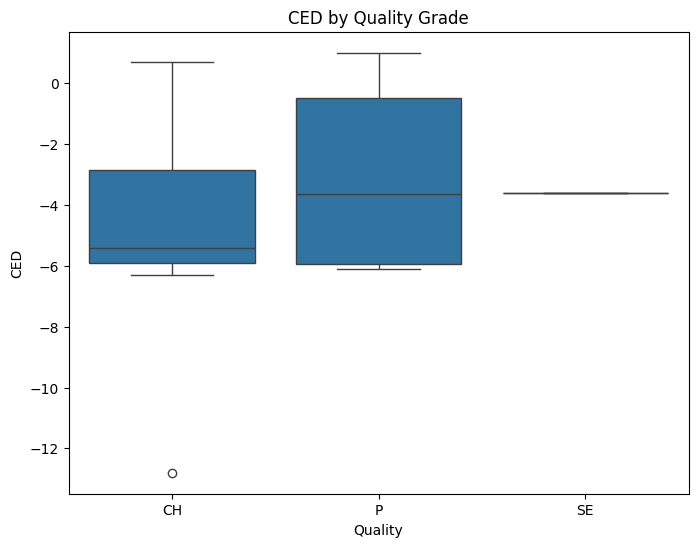

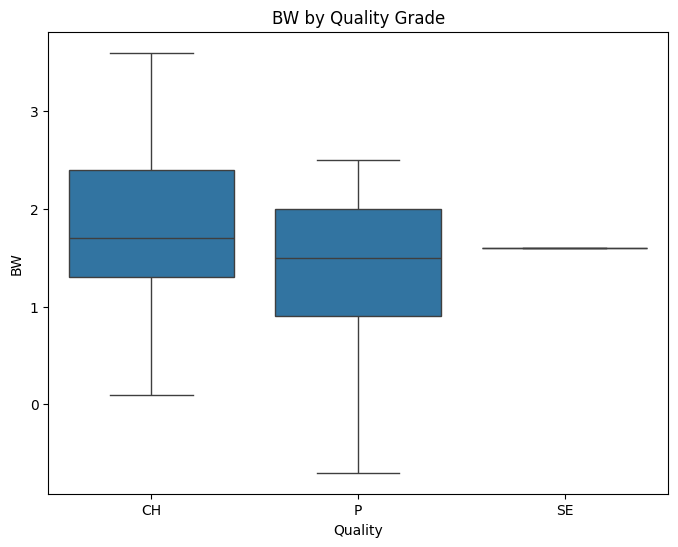

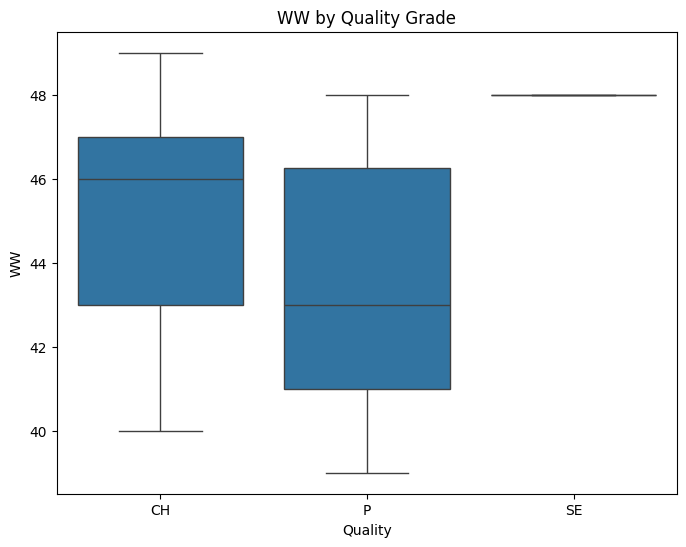

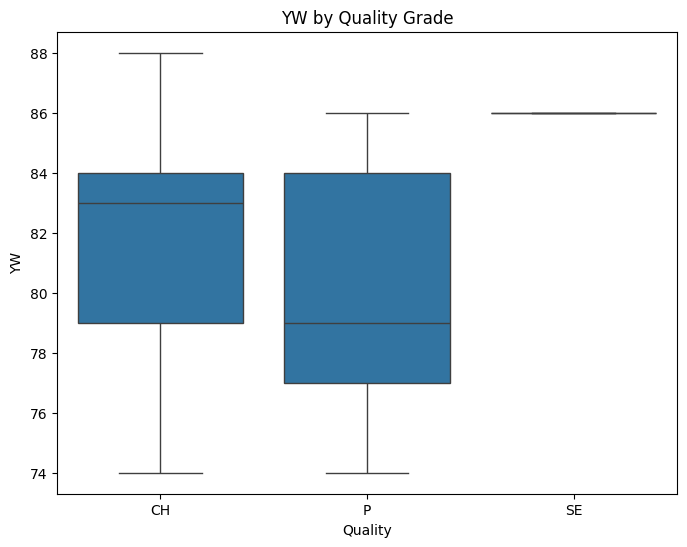

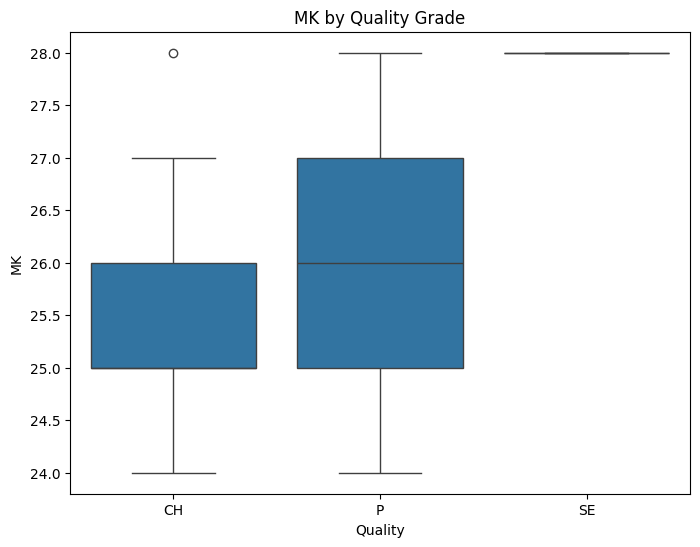

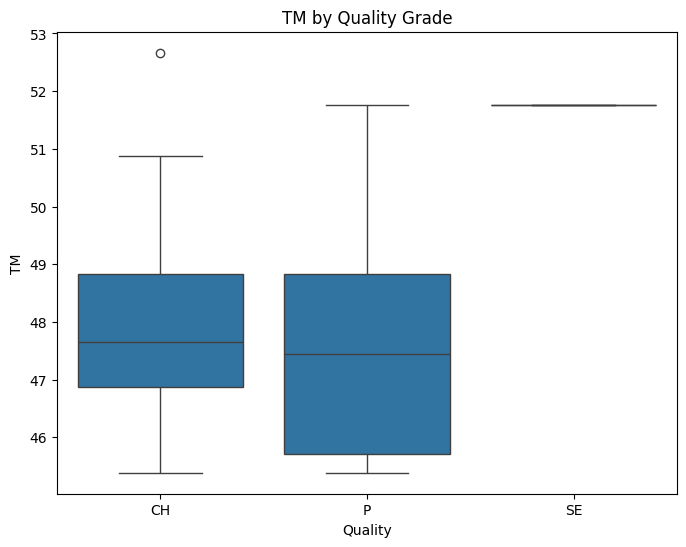

In [104]:
epd_columns = ['CED', 'BW', 'WW', 'YW', 'MK', 'TM']

for epd in epd_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Quality', y=epd, data=data)
    plt.title(f'{epd} by Quality Grade')
    plt.show()

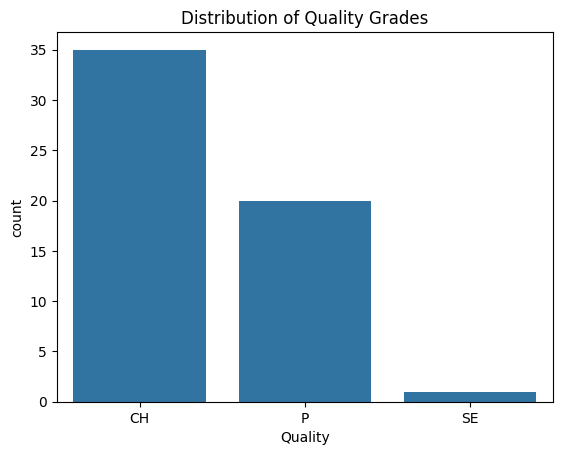

In [105]:
sns.countplot(x='Quality', data=data)
plt.title('Distribution of Quality Grades')
plt.show()

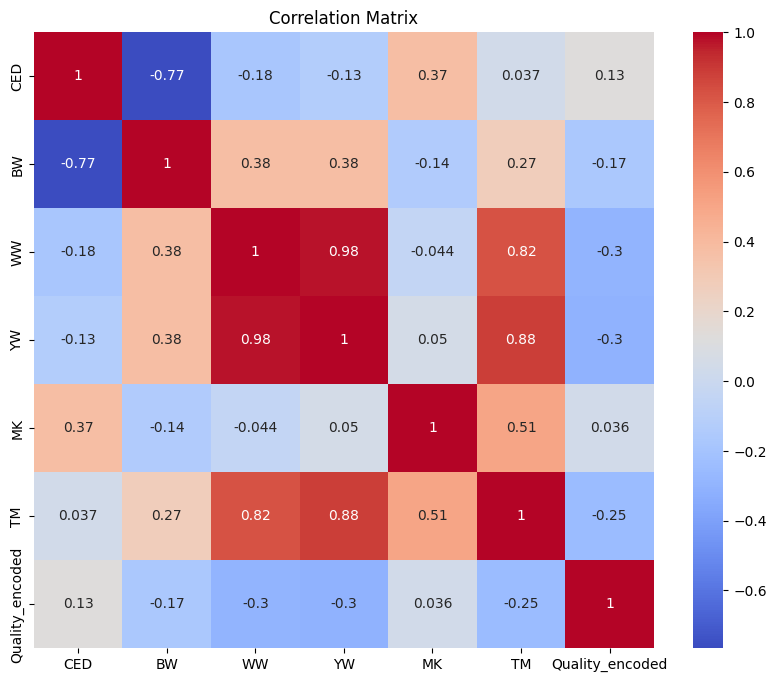

In [106]:
# Calculate correlation matrix
corr_matrix = data[epd_columns + ['Quality_encoded']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [107]:
import scipy.stats as stats

for epd in epd_columns:
    groups = data.groupby('Quality')[epd].apply(list)
    F, p = stats.f_oneway(*groups)
    print(f'ANOVA result for {epd}: F-statistic = {F:.2f}, p-value = {p:.4f}')

ANOVA result for CED: F-statistic = 0.57, p-value = 0.5684
ANOVA result for BW: F-statistic = 0.92, p-value = 0.4031
ANOVA result for WW: F-statistic = 2.82, p-value = 0.0688
ANOVA result for YW: F-statistic = 2.99, p-value = 0.0588
ANOVA result for MK: F-statistic = 3.15, p-value = 0.0511
ANOVA result for TM: F-statistic = 3.32, p-value = 0.0437


In [108]:
# Create a contingency table
contingency_table = pd.crosstab(data['Sire_Dam_encoded'], data['Quality_encoded'])

# Perform Chi-Squared test
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

print(f'Chi-Squared test: chi2 = {chi2:.2f}, p-value = {p:.4f}')

Chi-Squared test: chi2 = 112.00, p-value = 0.4290


In [113]:
data = data[data['Quality_encoded'] != 0]

# Update X and y
X = data[['CED', 'BW', 'WW', 'YW', 'MK', 'TM', 'Sire_encoded', 'Dam_encoded', 'Sire_Dam_encoded']]
y = data['Quality_encoded'].astype(int)

# Verify the class distribution after removal
print("Class distribution after removing class 0:")
print(y.value_counts())

Class distribution after removing class 0:
Quality_encoded
1    35
2    20
Name: count, dtype: int64


In [114]:
print("Unique values in 'Quality' column:", data['Quality'].unique())

Unique values in 'Quality' column: ['CH' 'P']


In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [112]:
# Check the class distribution in y
print("Class distribution in 'Quality_encoded':\n", y.value_counts())

Class distribution in 'Quality_encoded':
 Quality_encoded
1    35
2    20
0     1
Name: count, dtype: int64


In [116]:
from sklearn.ensemble import RandomForestClassifier

# Initialize classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

      Choice       0.40      0.29      0.33         7
       Prime       0.17      0.25      0.20         4

    accuracy                           0.27        11
   macro avg       0.28      0.27      0.27        11
weighted avg       0.32      0.27      0.28        11



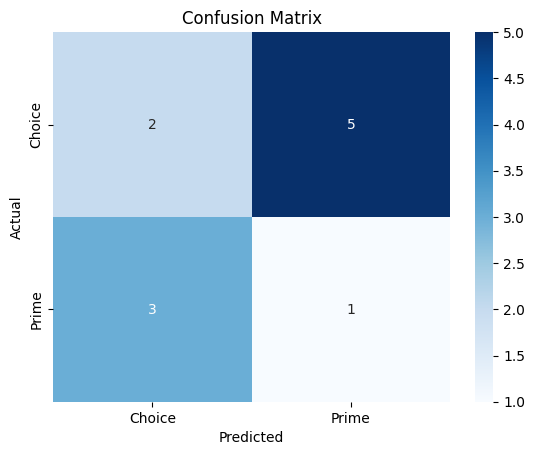

In [118]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=[ 'Choice', 'Prime']))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[ 'Choice', 'Prime'],
            yticklabels=[ 'Choice', 'Prime'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

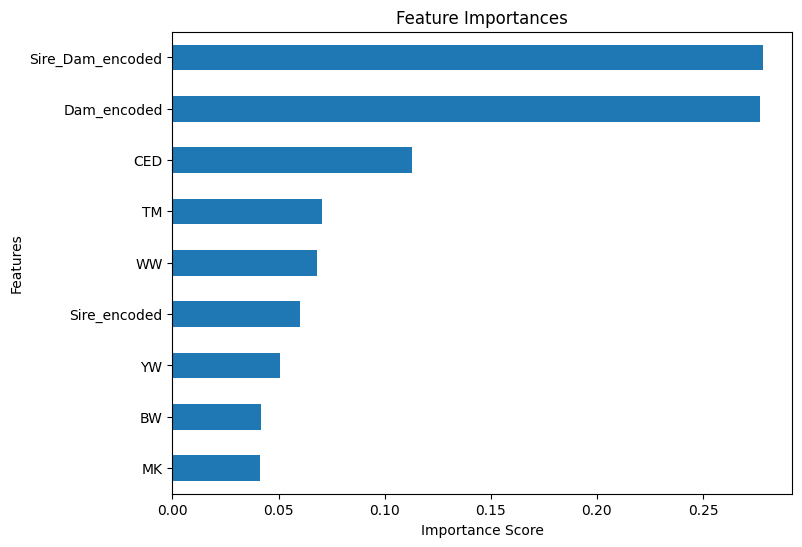

In [119]:
# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

# Plot feature importances
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [120]:
%pip install fastai

Defaulting to user installation because normal site-packages is not writeable
  Using cached fastdownload-0.0.7-py3-none-any.whl.metadata (5.5 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp312-cp312-win_amd64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp312-cp312-win_amd64.whl.metadata (8.6 kB)
  Using cached preshed-3.0.9-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached language_data-1.2.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.4 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.2 which is incompatible.
langchain-community 0.3.3 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.2 which is incompatible.
